# Distributed Data Processing and Sentiment Analysis of a Twitter Dataset

## 1. Overview

In this notebook, a Twitter data set was processed for time-series forecasting and manipulated in a distributed environment and NoSQL database.

The Twitter data was obtained from a Kaggle repository and the sentiment was extracted using the code implemented in this notebook.

The next sections of this notebook is organized as follows:

2. Auxiliary Functions

In this part, the main helper functions were implemented.

3. Data Storage Strategies

In this part, the dataset was uploaded to a Hadoop environment for distributed data processing experiments using PySpark.

To test the usage of a NoSQL database, a subset of the dataset was uploaded to an instance of MongoDB.

This part should be executed in a VM with Ubuntu and the required software up and running.

4. Sentiment Analysis and Time-Series Forecast

In this part, the dataset was processed using Text Processing techniques for the extraction of the sentiment of the tweets.

The final dataset was processed using time-series to perform experiments using ML to forecast the sentiment in different time windows.

This part can be executed in Windows environment with Anaconda and required Python libs installed.

## 2. Auxiliary Functions

In this section the auxiliary functions used in this project are implemented.

For this project, 2 Python helper modules were also implemented under jupyter/modules folder:

    - TextProcessor: Which has the methods to process the text using the approaches used in this project.
    - JsonHelper: It was used to convert dictionaries into JSON format.
    
The reason to separate these modules from the Jupyter notebooks was to keep the code organised and to follow the best programming practices with regards to reuse and code modularization.

In [1]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *

# importing modules specific to this notebook
import logging
import pandas as pd
#import altair as alt
#import seaborn as sns
import random
import concurrent.futures
import matplotlib.pyplot as plt
import zipfile
from wordcloud import WordCloud
from dotenv import dotenv_values
from nltk.probability import FreqDist
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_squared_error

# use a logger to help debugging
logger = logging.getLogger('ca2-jupyter')

# set logger level
logger.setLevel(logging.ERROR)

def unzip_file(zip_path, extract_path):
    '''
    Auxiliary function to unzip files.

    Parameters:
        zip_path     (str): Zip file path.
        extract_path (str): Path to unzip.
    '''
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    wordcloud.to_file(join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def process_tweets_chunk(chunk):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for tweet in chunk:
        tweet_raw = tweet
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)

        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    return proc_tweets

def process_tweets_async(tweets_list, chunk_size=1000):
    """
    Auxiliary method to process the tweets async in chunks using the process_tweets_chunk function.
    
    It uses threads to process the block of tweets concurrently.
      
    Parameters:
        tweets_list (lst): List of tweets to be processed.
        chunk_size (int): The size of the chunks.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    num_chunks = (len(tweets_list) + chunk_size - 1) // chunk_size

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(num_chunks):
            chunk = tweets_list[i*chunk_size:(i+1)*chunk_size]
            future = executor.submit(process_tweets_chunk, chunk)
            futures.append(future)

        for future in tqdm(concurrent.futures.as_completed(futures), total=num_chunks, desc='Processing'):
            proc_tweets.extend(future.result())

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def generate_random_timestamps_dataframe(year, num_dates):
    """
    Generate a DataFrame with sequential dates with several ramdom timestamps per day for a given year.

    Parameters:
        year (int): The year for which to generate the sequential dates.
        num_dates (int): The number of sequential dates to generate.
    Returns:
        DataFrame: A DataFrame containing the one year dates with random timestamps.
    """
    start_date = datetime(year, 1, 1)
    date_range = [start_date + timedelta(days=i) for i in range(365)]
    timestamp_per_day = int(num_dates/365)
    
    timestamps = []
    for date in date_range:
        timestamp_range = [date + timedelta(hours=random.randint(0, 23),
                                            minutes=random.randint(0, 59),
                                            seconds=random.randint(0, 59)) for _ in range(timestamp_per_day)]
        timestamps.extend(timestamp_range)

    df = pd.DataFrame({'Timestamp': timestamps})
    return df

def is_timeseries_complete(data):
    """
    Auxiliary function to determine if a timeseries dataset is complete.
    
    Parameters:
        data (df): Timeseries data to be checked.
    Return:
        True if is complete, False otherwise.
    """
    return (data.index == pd.date_range(start=data.index.min(), end=data.index.max(), freq=data.index.freq)).all()

def plot_train_test_graph(data_train, data_test, y_name, legend, filename):
    """
    Auxiliary function to plot train and test data into a graph.
    
    The output is saved into a file.
    
    Parameters:
        data_train (df): Train dataset.
        data_test (df): Test dataset.
        y_name (str): Target column name
        legend (str): Title of the graph
        filename (str): Filename to output
    """
    fig, ax = plt.subplots(figsize=(15, 4))
    data_train[y_name].plot(ax=ax, label='train')
    data_test[y_name].plot(ax=ax, label='test')
    plt.title(legend)
    plt.xlabel('date')
    plt.ylabel('average users sentiment')
    ax.legend();
    plt.savefig(join(IMAGES_FOLDER, filename), format='png')

## 3. Data Storage Strategies (VM)

The steps in this section should be executed in a VM with the proper software up and running as explained in the report accompaining this notebook.

The rest of this Jupyter notebook can run independetly of this step, since the datasets were also stored locally in a csv file.

### 3.1 Hadoop Experiments

In this step, Pyspark was used to retrieve the dataset from the Hadoop environment.

This process was implemented to demonstrate how a large dataset could be obtained from a distributed big data platform.

In this environment, Hadoop is hosted in a local VM, this way, due to hardware limitations, only this step of data acquisition was executed in the VM.

For this step to run properly, it was assumed that the following operations were performed previously in a terminal:

    1. Hadoop was started in the VM

    2. The dataset files was saved in the HDFS by using the commands:

         hadoop fs -put ./tweets_raw.csv /user1
         hadoop fs -put ./tweets_sentiment.csv /user1

In this experiment, the two datasets with the raw tweets and the one with the calculated sentiment were manipulated using PySpark.

The data was loaded into a data frame from the Hadoop environment using the API.

In [1]:
# importing pyspark libs
from pyspark.sql.types import *
from pyspark.sql.functions import when

In [2]:
# building the dataset schema
tweets_raw_cols = ['', 'userid', 'username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language', 'coordinates', 'favorite_count', 'extractedts']
col_type = [StructField(col, StringType(), True) for col in tweets_raw_cols]
tweet_raw_scheme = StructType(col_type)

# retrieving the data from the local hadoop environment
tweets_raw_df = spark.read.load('hdfs://localhost:9000/user1/tweets_raw.csv', format="csv", header="true", sep=',', schema=tweet_raw_scheme)

# printing the schema
tweets_raw_df.printSchema()

root
 |-- : string (nullable = true)
 |-- userid: string (nullable = true)
 |-- username: string (nullable = true)
 |-- acctdesc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- following: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- totaltweets: string (nullable = true)
 |-- usercreatedts: string (nullable = true)
 |-- tweetid: string (nullable = true)
 |-- tweetcreatedts: string (nullable = true)
 |-- retweetcount: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- language: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- extractedts: string (nullable = true)



In [3]:
# showing the first 5 rows
tweets_raw_df.show(5)

+--------------------+--------------------+--------+--------------------+--------+--------------------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------+--------+-----------+--------------+-----------+
|                    |              userid|username|            acctdesc|location|           following|followers|totaltweets|       usercreatedts|            tweetid|      tweetcreatedts|retweetcount|                text|hashtags|language|coordinates|favorite_count|extractedts|
+--------------------+--------------------+--------+--------------------+--------+--------------------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------+--------+-----------+--------------+-----------+
|                   0|            16882774| Yaniela|Animal lover, sup...|  Hawaii|                1158|      392|      88366|2008-10-21 07:34:...|15096819500421980

Getting the data from the sentiment dataset to add a new collumn with the index that represent each sentiment:
- Negative: 0
- Neutral: 1
- Positive: 2

In [4]:
# building the dataset schema
tweets_sent_cols = ['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm']
col_type = [StructField(col, StringType(), True) for col in tweets_sent_cols]
tweet_sent_schema = StructType(col_type)

# retrieving the data from the local hadoop environment
tweets_sent_df = spark.read.load('hdfs://localhost:9000/user1/tweets_sentiment.csv', format="csv", header="true", sep=',', schema=tweet_sent_schema)

# using pyspark function to create a new column with the index of the sentiment
tweets_sent_df = tweets_sent_df.withColumn("sent_clr_index", when(tweets_sent_df.sent_clr == "neutral", "1")
                                                            .when(tweets_sent_df.sent_clr == "positive","2")
                                                            .otherwise("0"))
tweets_sent_df[['sent_clr_index', 'sent_clr']].show(5)

+--------------+--------+
|sent_clr_index|sent_clr|
+--------------+--------+
|             1| neutral|
|             0|    null|
|             1| neutral|
|             1| neutral|
|             1| neutral|
+--------------+--------+
only showing top 5 rows



### 3.2 Data Storage on MongoDB

In this step, the datasets obtaiend from the Hadoop environment were stored in MongoDB.

This step was also implemented to demonstrate how a large dataset could be manipulated using a NoSQL database.

For this experiment, a VM was prepared with MongoDB environment previously configured.

In [5]:
#pip install pymongo==3.11.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
#!pip install pandas pymongo
from pymongo import MongoClient
import pandas as pd

For performances reasons, only part of the dataset was uploaded to the database.

In [7]:
# limiting the size for performance reasons
tweets_raw_mongo_df = tweets_raw_df.limit(1000)

In [8]:
# mongodb connection details
mongodb_uri = 'mongodb://localhost:27017/'
database_name = 'cct-ca2'
collection_name = 'twitter'

# connect to mongodb
client = MongoClient(mongodb_uri)
db = client[database_name]
collection = db[collection_name]

# convert data to a list of dictionaries
data_dict = [row.asDict() for row in tweets_raw_mongo_df.rdd.collect()]

# insert data into database
collection.insert_many(data_dict)

# close connection
client.close()

## 4. Sentiment Analysis and Time-Series Forecast

The dataset used was obtained from a <a href="https://www.kaggle.com/code/ssaisuryateja/eda-and-sentiment-analysis/input">Kaggle repository</a> and it is about Twitter's users comments on the war in Ukraine in 2022.

This large dataset was processed for sentiment analysis and time-series to forcast the sentiment of tweets over a period of time.

The following sections cover the EDA steps and the sentiment and time-series analysis.

### 4.1 Data Pre-Processing

In this step the raw data was collected from the zip files that contain the csv datasets.

As part of this step, it was handled null values and the columns were properly converted into their data types.

In [2]:
# zip files with the dataset
tweets_raw_zip = join(DATASETS_FOLDER, 'tweets_raw.zip')
tweets_sent_zip = join(DATASETS_FOLDER, 'tweets_sentiment.zip')

# unzip the files
unzip_file(tweets_raw_zip, DATASETS_FOLDER)
unzip_file(tweets_sent_zip, DATASETS_FOLDER)

In [3]:
# getting tweets from the archive
dataset = pd.read_csv(TWEETS_DS_RAW, encoding='utf-8')

# dataset column names
tweets_cols = ['username', 'tweetid', 'text', 'hashtags', 'language', 'extractedts']

# storing the dataset in a variable for processing
tweets_df = dataset[tweets_cols]

# converting date column into proper date type
tweets_df['extractedts'] = pd.to_datetime(tweets_df['extractedts'])

# data size
print(f'Dataset size: {len(tweets_df)}')

Dataset size: 364875


In [4]:
# checking for null values
pd.DataFrame(tweets_df.isnull().sum(), columns=['Null Values'])

,Null Values
username,0
tweetid,0
text,0
hashtags,0
language,0
extractedts,0


In [5]:
# describing the data
tweets_df.describe(include='all')

,username,tweetid,text,hashtags,language,extractedts
count,364875,3.648750e+05,364875,364875,364875,364875
unique,166400,NaN,104548,85962,61,364875
top,FuckPutinBot,NaN,⚡The Ukrainian Air Force would like to address...,[],en,2022-04-01 00:44:20.097867
freq,789,NaN,7297,72345,254626,1
first,NaN,NaN,NaN,NaN,NaN,2022-04-01 00:01:44.294934
last,NaN,NaN,NaN,NaN,NaN,2022-04-02 00:46:57.116538
mean,NaN,1.509875e+18,NaN,NaN,NaN,NaN
std,NaN,9.829062e+13,NaN,NaN,NaN,NaN
min,NaN,1.509682e+18,NaN,NaN,NaN,NaN
25%,NaN,1.509795e+18,NaN,NaN,NaN,NaN


The original dataset covers only a short period of time as shown below.

In [6]:
# showing the date covereage in this dataset
tweets_df['extractedts'].min(), tweets_df['extractedts'].max()

(Timestamp('2022-04-01 00:01:44.294934'),
 Timestamp('2022-04-02 00:46:57.116538'))

This way, for the sake of the experimentation proposed in the brief of this project, a synthetic Timestamp column was generated to cover the period of one year.

Although this change affects the analysis of the data in terms of reality, as the timestamps are artificial, it doesn't affect the outcome of the project.

Thus, the strategy used was to create one year of sequential dates with random timestamps that cover the whole year of 2022.

In [7]:
# generate random dates covering the period of one year
random_dates_column = generate_random_timestamps_dataframe(2022, len(tweets_df))

# displaying the first entries
random_dates_column.head()

,Timestamp
0,2022-01-01 07:16:11
1,2022-01-01 02:50:53
2,2022-01-01 05:04:08
3,2022-01-01 17:49:46
4,2022-01-01 05:57:55


This way, the tweets dataset are now covering one year period as expected. 

In [8]:
# showing the date covereage in this dataset
random_dates_column['Timestamp'].min(), random_dates_column['Timestamp'].max()

(Timestamp('2022-01-01 00:00:13'), Timestamp('2022-12-31 23:57:18'))

In [9]:
# checking there are only 365 days in the dates column
len(random_dates_column['Timestamp'].dt.date.unique())

365

### 4.2 Text Processing for Sentiment Analysis

For this project, the raw tweets were processed and the following columns were generated:

    tweet_raw, sent_raw: Original tweets + sentiment.

    tweet_str, sent_str: Tweets after the removal of special characters + sentiment.

    tweet_clr, sent_clr: Tweets after the removal of special characters and stop words + sentiment.

    tweet_st, sent_st: Tweets after the removal of special characters, stop words and application of Porter Stemmer + sentiment.

    tweet_lm, sent_lm: Tweets after the removal of special characters, stop words and application of Lemmatizer + sentiment.

The sentiment was calculated for each version of the tweet because it was observed the results were different.

The algorithm used to extract the sentiment from the Tweets were obtained from TextBlob. The possible sentiments were: positive, negative and neutral.

Since this is a time consuming process, the tweets were processed previously and stored in a csv file in the datasets folder.

So, the next code block can be skipped as the processed tweets will be obtained directly from the csv file.

In [70]:
# NOTE: YOU CAN SKIP THIS CODE BLOCK.
# ONLY RUN THIS CODE IF YOU WANT TO RE-CALCULATE THE SENTIMENT OF THE RAW TWEETS
# THIS IS TIME-CONSUMING SO EVEN WITH A MULTI-THREAD STRATEGY TO PROCESS THE TWEETS 
# IN CHUNKS IT TAKES A LONG TIME TO FINISH.

# getting the tweets list from the dataframe
tweets_list = tweets_df['text'].values

# processing retrieved data using text processing
tweets_proc = process_tweets_async(tweets_list)

# creating a csv file in the output folder for the full dataset
tweets_proc.to_csv(TWEETS_SENT, index=False)

# display the first rows
tweets_proc.head()

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [53:19<00:00,  8.77s/it]


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


In [10]:
# getting tweets from the archive
tweets_proc = pd.read_csv(TWEETS_SENT, encoding='utf-8')

# size of the data
print(f'{len(tweets_proc)}')

# display the first rows
tweets_proc.head()

364875


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


### 4.3 Dataset Concatenation

In this step the dataset is combined so all the tweets have their sentiment and artificial timestamps allocated properly.

As part of this step, the null values are also removed from the combined dataset.

In [11]:
len(tweets_df), len(tweets_proc), len(random_dates_column)

(364875, 364875, 364635)

In [12]:
# concatenate the sentiment and the original dataset
tweets_final = pd.concat([tweets_df, tweets_proc, random_dates_column], axis=1)

print(f'{len(tweets_final)}')

# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# ramdom date
col_date = ['Timestamp']

# keeping only the relevant columns for the analysis
col_names = X_names + y_names + col_date
tweets_final = tweets_final[col_names].sort_values(by='Timestamp')
tweets_final.head()

364875


,tweet_str,tweet_clr,tweet_st,tweet_lm,sent_str,sent_clr,sent_st,sent_lm,Timestamp
123,kira is her mother died when she was littl...,kira mother died little dad killed mariupol tr...,kira mother die littl dad kill mariupol tri es...,kira mother died little dad killed mariupol tr...,negative,negative,positive,negative,2022-01-01 00:00:13
39,roskomnadzor appealed to the administration of...,roskomnadzor appealed administration wikipedia...,roskomnadzor appeal administr wikipedia reques...,roskomnadzor appealed administration wikipedia...,positive,positive,positive,positive,2022-01-01 00:00:51
143,this is a very very good idea from toomas as...,good idea toomas long russia deports ukrainian...,good idea tooma long russia deport ukrainian o...,good idea toomas long russia deports ukrainian...,positive,positive,positive,positive,2022-01-01 00:07:12
415,the site is and is already a growing platform...,site already growing platform ukrainians share...,site alreadi grow platform ukrainian share sto...,site already growing platform ukrainians share...,neutral,neutral,neutral,neutral,2022-01-01 00:07:43
493,ukrainian armed forces liberated settlement...,ukrainian armed forces liberated settlements k...,ukrainian arm forc liber settlement kherson re...,ukrainian armed forces liberated settlements k...,neutral,neutral,neutral,neutral,2022-01-01 00:11:27


In [13]:
# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,2
tweet_st,2
tweet_lm,2
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
Timestamp,240


In [14]:
# removing null values
tweets_final = tweets_final.dropna()

# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,0
tweet_st,0
tweet_lm,0
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
Timestamp,0


### 4.4 Tweets Dataset Visualization

Word cloud are common ways to visualize text datasets, so it is possible to have an idea of its main content.

The word cloud below was generated over the cleaned tweets after the removal of special characters and stop words.

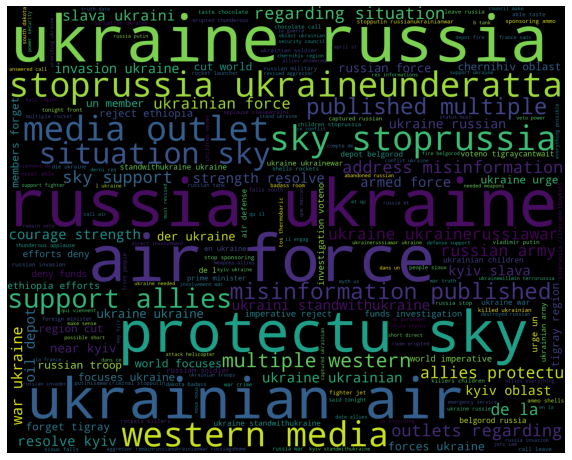

In [15]:
#wordcloud_draw(tweets_final['tweet_clr'])
Image(filename=join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))

In [15]:
# get the count of users expressing a particular sentiment (neutral, pos or neg)
# from the dataset
for sent in y_names:
    # group data by sentiment
    grouped_df = tweets_final.groupby(sent)

    # count the number of rows with that sentiment
    count_values = grouped_df[sent].count()

    # print the resulting aggregated data
    print(count_values)

sent_str
negative     58350
neutral     187658
positive    118625
Name: sent_str, dtype: int64
sent_clr
negative     59894
neutral     203118
positive    101621
Name: sent_clr, dtype: int64
sent_st
negative     48908
neutral     230836
positive     84889
Name: sent_st, dtype: int64
sent_lm
negative     63110
neutral     200654
positive    100869
Name: sent_lm, dtype: int64


Overall, the diferent text processing techniques applied to the raw tweets didn't change the big picture, which shows more neutral comments about the war than positives or negatives.

This sentiment analysis alone cannot explain what happend with this particular dataset, as it can't be garanteed that all tweets are making judgements about the war, for example.

While this dataset contains only tweets about this topic, several subjects can be talked about in social media, which makes it hard to extract more information from it with regards to what is the feeling of the people towards the conflict.

### 4.5 Time-Series Forecast

For the time-series forecast the sentiment calculated over the cleaned tweets (tweet_clr) will be used, which refers to the sent_clr column in the dataset.

#### 4.5.1 Data Preparation

In order to have an idea of how the sentiment of users fluctuate over the days on this topic, the following approach was taken to configure the dataset into a time-series.

- Get all sentiments per day from the dataset.
- Get the average sentiment for the day using the numerical value that represents the sentiments.
- Summarize the dataset by day and get the average value for the sentiment to represent the day.

In the next steps, the dataset is converted into a time-series using the approach above.

In [16]:
# possible sentiments in the dataset
sentiment_lst = ['negative', 'neutral', 'positive']

# converting the string sentiment into numerical value
tweets_final['sent_clr_index'] = tweets_final['sent_clr'].apply(lambda x: sentiment_lst.index(x))

# show the result
tweets_final[['Timestamp', 'tweet_clr', 'sent_clr', 'sent_clr_index']].head()

,Timestamp,tweet_clr,sent_clr,sent_clr_index
123,2022-01-01 00:00:13,kira mother died little dad killed mariupol tr...,negative,0
39,2022-01-01 00:00:51,roskomnadzor appealed administration wikipedia...,positive,2
143,2022-01-01 00:07:12,good idea toomas long russia deports ukrainian...,positive,2
415,2022-01-01 00:07:43,site already growing platform ukrainians share...,neutral,1
493,2022-01-01 00:11:27,ukrainian armed forces liberated settlements k...,neutral,1


In [17]:
# summaryze the data by date
grouped_df = tweets_final.groupby(tweets_final['Timestamp'].dt.date)['sent_clr_index'].mean().reset_index()
#grouped_df = df.groupby(df['Timestamp'].dt.date)['sent_clr_index'].agg(lambda x: x.mode()[0]).reset_index()

# setting column names
grouped_df.columns = ['date', 'sent_mean']

# setting date as index
grouped_df = grouped_df.set_index('date')

# setting the frequencyt by day
grouped_df = grouped_df.asfreq('d')

# Print the resulting aggregated data
grouped_df = grouped_df.sort_index()
grouped_df

,sent_mean
date,
2022-01-01,1.197197
2022-01-02,1.166166
2022-01-03,1.194194
2022-01-04,1.151151
2022-01-05,1.206206
...,...
2022-12-27,1.112112
2022-12-28,1.152152
2022-12-29,1.118118


Double checking for missing values after the pre-processing.

In [18]:
print(f'Rows with missing values: {grouped_df.isnull().any(axis=1).mean()}')

Rows with missing values: 0.0


Verifying of the time-series is complete using auxiliary function.

In [19]:
is_timeseries_complete(grouped_df)

True

#### 4.5.1 Time-Series Visualization

In this step, the time series that represents the average daily sentiment of Twitter's users on the Ukrainian war subject in 2022 is configured.

In [20]:
# parameter for the experiment
pred_steps = 30

# split the data into train and test data
data_train = grouped_df[:-pred_steps]
data_test = grouped_df[-pred_steps:]

# print the train and test data details
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()}  --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2022-01-01 00:00:00 --- 2022-12-01 00:00:00 (n=335)
Test dates  : 2022-12-02 00:00:00  --- 2022-12-31 00:00:00  (n=30)


The last 30 days of the time-series are higlighted to demonstrate how the forecasting algorithm works, as it uses the chosen previous intervals (30 days) to projec the future.

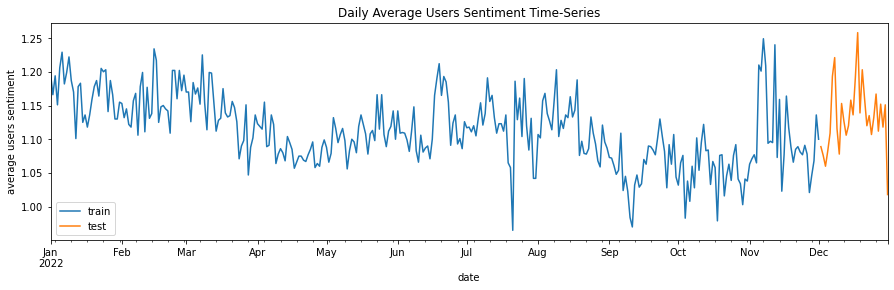

In [21]:
# target variable name
y = 'sent_mean'

# plot the graph
plot_train_test_graph(data_train, data_test, y, 'Daily Average Users Sentiment Time-Series', 'time-series_data.png')

#### 4.5.1 Time-Series Prediction

In this step, a recursive multi-step forecasting is used to project the average daily user's sentiment at 1 week, 1 month and 3 months going forward.

In [22]:
# instanciate forcaster using last 30 days as reference
forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=42), lags=pred_steps)

# fit the model using the training dataset (first 335 days of the year)
forecaster.fit(y=data_train[y])

# display the model parameters
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Transformer for y: None 
Transformer for exog: None 
Window size: 30 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-05-25 12:00:46 
Last fit date: 2023-05-25 12:

Test error (mse) for 7 days: 0.0024337467168297914
Test error (mse) for 30 days: 0.002817410872294454
Test error (mse) for 90 days: 0.003812796969271875


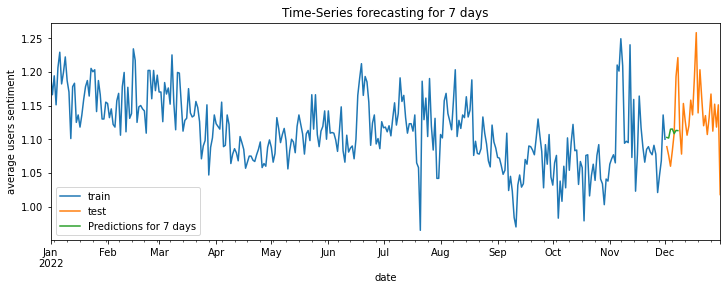

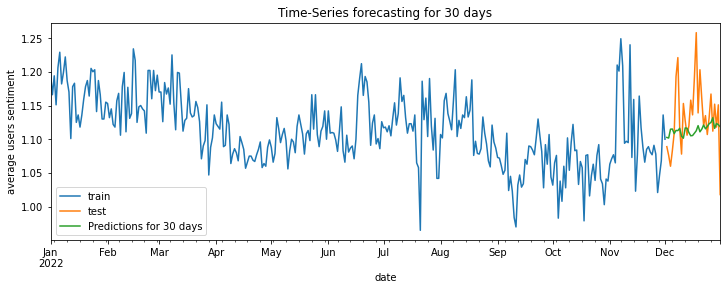

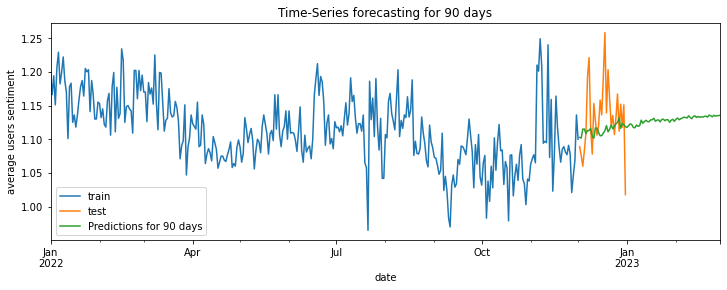

In [24]:
# using the following days as the lags parameter to predict
pred_lags_days = [7, 30, 90]

# predict the data forward using the values
for step_ff in pred_lags_days:
    # make a prediction given the steps as input
    predictions = forecaster.predict(steps=step_ff)

    # plot the prediction in the graph    
    fig, ax = plt.subplots(figsize=(12, 4))
    data_train[y].plot(ax=ax, label='train')
    data_test[y].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label=f'Predictions for {step_ff} days')
    plt.title(f'Time-Series forecasting for {step_ff} days')
    plt.xlabel('date')
    plt.ylabel('average users sentiment')
    ax.legend();
    
    # saving graph as image
    plt.savefig(join(IMAGES_FOLDER, f'time-series-{step_ff}.png'), format='png')

    # getting the truth data for the error calculation
    data_test_err = grouped_df[-step_ff:]
    
    # calculate the prediction error
    error_mse = mean_squared_error(y_true=data_test_err[y], y_pred=predictions)
    print(f"Test error (mse) for {step_ff} days: {error_mse}")

### 4.6 Interactive Dashboard

In this section an interactive dashboard was implemented using TK-Inter, where the user can select the different time-series predictions using a dropdown menu.

In [25]:
import tkinter as tk
from PIL import ImageTk, Image
from tkinter import Label

# time-series graphs available
time_series_imgs = {step: join(IMAGES_FOLDER, f"time-series-{step}.png") for step in pred_lags_days} 

# function to update the displayed image
def update_image(*args):
    selected_image = dropdown.get()

    # Load the selected image
    image_path = time_series_imgs.get(int(selected_image), "")

    # Update the image
    if image_path:
        img = Image.open(image_path)
        img = img.resize((900, 400))
        photo = ImageTk.PhotoImage(img)
        image_label.configure(image=photo)
        image_label.image = photo
    else:
        image_label.configure(image="")
        image_label.image = None

# create the main window
window = tk.Tk()
window.title("Time-Series Forecasting")

# adding label to the window
label= Label(window, text= "Select the number of days for the prediction", font= ("", 10))
label.pack(pady=30)

# getting dropdown options
images_list = list(time_series_imgs.keys())

# create the dropdown menu
dropdown = tk.StringVar()
dropdown_menu = tk.OptionMenu(window, dropdown, *images_list, command=update_image)
dropdown_menu.pack()

# create the label to display the image
image_label = tk.Label(window)
image_label.pack()

# start the main event loop
window.mainloop()

In [127]:
 # Hyperparameter Grid search
# ==============================================================================
steps = 20
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 12)

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
    forecaster = forecaster, 
    y = data_train['Mode'], 
    param_grid = param_grid, 
    lags_grid = lags_grid,
    steps = steps,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(data_train)*0.5),
    fixed_train_size = False,
    return_best = True,
    verbose = False)


Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.003252830354636733



In [128]:
 # Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.003253,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.003265,5,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.003266,3,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.003360,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.003445,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.003455,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.003681,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.003704,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.003715,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.003753,10,100


In [129]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
 regressor = regressor,
 lags = 20
 )
forecaster.fit(y=data_train['Mode'])

In [130]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

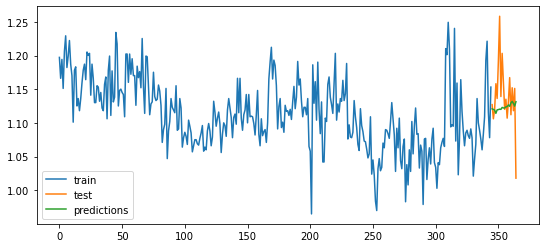

In [131]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Mode'].plot(ax=ax, label='train')
data_test['Mode'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [132]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
 y_true = data_test['Mode'],
 y_pred = predictions
 )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00257903815676723
